## Model description

This model corresponds to the "classical" bouncing ball. It is perhaps the simplest example of a hybrid ODE, since it presents only one discrete transition. The model consists of a ball dropped from a predefined height. It hits the ground after a certain time, loses energy and then bounces back into the air and starts to fall again.

This model has 2 continuous variables, 1 mode and 1 discrete jump.

The physical phenomena can be represented as the following hybrid automaton:

<img src="BouncingBall.png" alt="Drawing" style="width: 300px;"/>

In the discrete state, the motion of the ball, assumed to have a mass of $m = 1 kg$, is governed by the following differential equation:

$$
\begin{array} \\x'(t)= & v(t)\\ v'(t) = & -9.81 \end{array}
$$
where $x$ is the ball’s height from the ground, $v$ is the ball’s vertical velocity, and $9.81ms^{-2}$ is the earth’s gravitational force.

The invariant $x \geq 0$ enforces that the ball always bounces when it reaches the ground. The guard $x=0 \wedge v\leq0$ of the single discrete transition, which models the bouncing, ensures that bouncing happens after falling when reaching the ground. The corresponding reset condition $v:=-c \cdot v$ accounts for the loss of energy due to the ball’s deformation, where $c\in\left[0,1\right]$ is a constant known as [coefficient of restitution](https://en.wikipedia.org/wiki/Coefficient_of_restitution).

The model parameters and description are taken from the [HyPro collection of continuous and hybrid system benchmarks](https://ths.rwth-aachen.de/research/projects/hypro/).

In [1]:
using Revise # to debug
using Reachability, HybridSystems, MathematicalSystems, LazySets, LazySets.Approximations, LinearAlgebra 

┌ Info: Recompiling stale cache file /Users/forets/.julia/compiled/v1.1/Reachability/CHV4V.ji for Reachability [774a0091-654f-5c65-bbdc-ad5b67b45832]
└ @ Base loading.jl:1184
┌ Warning: Package LazySets does not have Expokit in its dependencies:
│ - If you have LazySets checked out for development and have
│   added Expokit as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with LazySets
│ Loading Expokit into LazySets from project dependency, future warnings for LazySets are suppressed.
└ @ nothing nothing:840


In [2]:
function bouncing_ball(;c = 0.75,
                       X0 = Interval(10.0, 10.2) × Interval(0, 0),
                       T = 40.0)

    # automaton structure
    automaton = LightAutomaton(1)

    # falling : x' = Ax + b, x ∈ X
    A = [0.0 1.0;
         0.0 0.0]
    b = [0.0,
        -9.81]
    X = HalfSpace([-1.0, 0.0], 0.0) # x >= 0
    falling = ConstrainedAffineContinuousSystem(A, b, X)
        
    # modes
    modes = [falling]

    # transition from mode falling to mode falling (self-loop)
    add_transition!(automaton, 1, 1, 1)
    
    # reset map (x, v) -> (x, -cv) with guard x == 0 and v <= 0
    A = [1.0 0.0;
         0.0 -c]
    
    guard = HPolyhedron([HalfSpace([0.0, 1.0], 0.0),   # v ≤ 0
                         HalfSpace([-1.0, 0.0], 0.0),  # x ≥ 0
                         HalfSpace([1.0, 0.0], 0.0)])  # x ≤ 0
    
    resetmaps = [ConstrainedLinearMap(A, guard)]

    # switching
    switchings = [AutonomousSwitching()]

    ℋ = HybridSystem(automaton, modes, resetmaps, switchings)

    # initial condition in "falling" mode
    initial_condition = [(1, X0)]

    problem = InitialValueProblem(ℋ, initial_condition)

    options = Options(:mode=>"reach", :T=>T, :plot_vars=>[1, 2])

    return (problem, options)
end

bouncing_ball (generic function with 1 method)

## Reachability settings

We consider the inital set given by an uncertain initial position and certain momentum (at rest):

$$
 x \in [10, 10.2], v = 0.
$$

We use a time horizon of $T=40s$ and set the constant $c = 0.75$.
The set of *bad states* is the set of all states where $v \geq 10.7$.

In [3]:
# settings
c = 0.75
X0 = Interval(10.0, 10.2) × Interval(0, 0)
T = 20.0

BouncingBall, options = bouncing_ball(c=c, X0=X0, T=T);
BadStates = HalfSpace([0.0, -1.0], -10.7); # v >= 10.7

## Results

In [4]:
using Plots, LaTeXStrings

In [26]:
#=
doesn't work -- why?
@time begin
    sol = solve(BouncingBall, merge!(Options(:max_jumps=>0), options),
                BFFPSV18(:δ=>0.1, :block_options=>OctDirections));
end;
=#


#=
@time begin
    opts = merge!(Options(:max_jumps=>1, :project_reachset=>false, :verbosity=>1), options)
    opC = GLGM06(:δ=>0.1, :max_order=>2)
    opD = LazyDiscretePost(:check_invariant_intersection=>true,
                           :lazy_R⋂I=>false, :overapproximation=>OctDirections)
    
    sol = solve(BouncingBall, opts, opC, opD)
end;
MethodError: Cannot `convert` an object of type HPolytope{Float64} to an object of type Zonotope
=#

#=
@time begin
    opts = merge!(Options(:max_jumps=>1, :project_reachset=>true, :set_type_proj=>HPolygon,
                          :verbosity=>0), options)
    opC = BFFPSV18(:δ=>0.1, :partition=>[1:2], :block_options=>OctDirections)
    opD = LazyDiscretePost(:check_invariant_intersection=>false,
                           :lazy_R⋂I=>true, :overapproximation=>OctDirections)
    sol = solve(BouncingBall, opts, opC, opD);
end;
=#

@time begin
    opts = merge!(Options(:max_jumps=>1, :project_reachset=>true, :set_type_proj=>HPolygon,
                          :verbosity=>0), options)
    opC = BFFPSV18(:δ=>0.1, :partition=>[1:2], :block_options=>OctDirections)
    opD = LazyDiscretePost(:check_invariant_intersection=>true,
                           :lazy_R⋂I=>false, :overapproximation=>OctDirections)
    sol = solve(BouncingBall, opts, opC, opD);
end;

[warn] Several option aliases were used for aliases Symbol[:check_invariant_intersection].
[warn] Several option aliases were used for aliases Symbol[:overapproximation].
[warn] Several option aliases were used for aliases Symbol[:lazy_R⋂I].
OctDirections
16
  1.257827 seconds (2.01 M allocations: 100.213 MiB, 7.06% gc time)


In [21]:
sol.options.dict

Dict{Symbol,Any} with 16 entries:
  :property                  => nothing
  :ε_proj                    => Inf
  :n                         => 2
  :verbosity                 => 0
  :coordinate_transformation => ""
  :plot_vars                 => [1, 2]
  :inout_map                 => [1, 2]
  :set_type_proj             => HPolygon
  :max_jumps                 => 1
  :mode                      => "reach"
  :transformation_matrix     => nothing
  :clustering                => :chull
  :T                         => 20.0
  :projection_matrix         => nothing
  :project_reachset          => true
  :fixpoint_check            => :eager

In [22]:
constraints_list(sol.Xk[1].X)

4-element Array{HalfSpace{Float64},1}:
 HalfSpace{Float64}([1.0, 0.0], 10.24905)            
 HalfSpace{Float64}([0.0, 1.0], 2.55351295663786e-15)
 HalfSpace{Float64}([-1.0, 0.0], -9.950949999999999) 
 HalfSpace{Float64}([0.0, -1.0], 0.9810000000000025) 

In [23]:
constraints_list(sol.Xk[2].X)

4-element Array{HalfSpace{Float64},1}:
 HalfSpace{Float64}([1.0, 0.0], 10.293195)          
 HalfSpace{Float64}([0.0, 1.0], -0.9809999999999975)
 HalfSpace{Float64}([-1.0, 0.0], -9.803799999999999)
 HalfSpace{Float64}([0.0, -1.0], 1.9620000000000026)

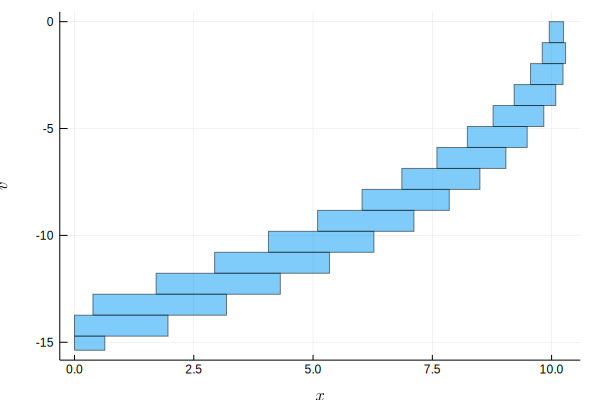

In [24]:
plot(sol, xlab=L"x", ylab=L"v", alpha=.5)

In [ ]:
plot(sol, xlab=L"x", ylab=L"v", alpha=.5)

In [ ]:
# just checking the flowpipe for the "falling" mode:

In [ ]:
X0

In [ ]:
# falling : x' = Ax + b, x ∈ X
A = [0.0 1.0;
     0.0 0.0]

b = [0.0,
    -9.81]

problem = IVP(AffineContinuousSystem(A, b), X0)
options = Options(:mode=>"reach", :T=>10., :plot_vars=>[1, 2])

# produces box flowipe
sol = solve(problem, options, op=BFFPSV18(:δ=>1.0));

using LazySets.Approximations

# produces box flowipe -- not too accurate, compare w/zonotopes 
#sol = solve(problem, options, op=BFFPSV18(:δ=>0.1));

# should produce octagons -- doesn't work !
#sol = solve(problem, options, op=BFFPSV18(:δ=>0.01, :partition=>[1:2],
#            :block_options=>OctDirections));

# use zonotope-based algorithm
@time sol = solve(problem, options, op=GLGM06(:δ=>0.1, :max_order=>2));

In [ ]:
plot([sol.Xk[i].X for i in eachindex(sol.Xk)], alpha=.5, color=:lightblue)